## Simple circuit Extraction Demo notebook

In [1]:
#hardware
device = 'cuda:0'

#model loading
from torchvision import models
model = models.alexnet(pretrained=True)
model = model.to(device)

#dissect model (version of model with intermediate activation maps)
from copy import deepcopy
from circuit_pruner.dissected_Conv2d import dissect_model
dissected_model = dissect_model(deepcopy(model), store_ranks = True, device=device)
dissected_model = dissected_model.to(device)



/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla K40c with CUDA capability sm_35 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the Tesla K40c GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


### Circle Scale circuits

Identity of our target 'spiral detector' neuron

In [2]:
layer = 'features_8'
unit = 53

visualization of 'spiral' target neuron

100%|██████████| 512/512 [00:27<00:00, 18.86it/s]



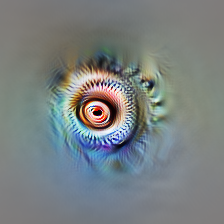

In [3]:
from lucent_fresh.optvis import render, param, transform, objectives   #lucent fresh is a version of lucent with some of my edits
from lucent_fresh.modelzoo.util import get_model_layers

param_f = lambda: param.image(224)
obj  = objectives.neuron(layer,unit)
_ = render.render_vis(dissected_model,  obj, param_f, transforms=None, show_inline=True) #weird hack here using the 'dissected_model' works better for neuron-wise feature visualizations, not sure why

We extract circuits with respect to input images, lets look at the two images we'll use

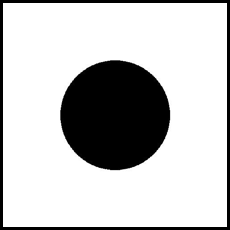

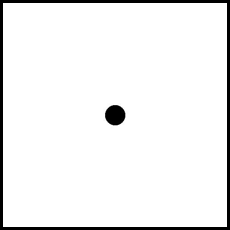

In [6]:
root_image_folder = 'image_data/sample_data/circles/'

from PIL import Image, ImageOps
big_circle_img = Image.open(root_image_folder+'big_circle.jpg')
small_circle_img = Image.open(root_image_folder+'small_circle.jpg')
big_circle_img = big_circle_img.resize((224,224))
small_circle_img = small_circle_img.resize((224,224))


#displaying with a border to get a sense of scale within image
border = (3, 3, 3, 3)
big_circle_wt_border = ImageOps.expand(big_circle_img, border=border, fill='black')
small_circle_wt_border = ImageOps.expand(small_circle_img, border=border, fill='black')
display(big_circle_wt_border)
display(small_circle_wt_border)

circle_images = {'big':big_circle_img,'small':small_circle_img}

One thing that comes up again and again, which we will utilize here, is the calculation of analytical receptive fields. For example, the above images have dots drawn in the center at different sizes, but it is unclear how these dots line up with the receptive field of our target 'spiral' neuron (there is a unique receptive field in pixel space associated with each activation in the activation map for this neuron). What we'd like to do is resize and position the above images on a blank 224x224 image, such that they exactly line-up with a particular receptive field for one activation in the activation map of our target neuron. To do this, we need to know exactly where these receptive fields are in pixel space. Luckily, these can be calculated from the model architecture analytically, as is done below. 

In [7]:
from circuit_pruner.receptive_fields import receptive_field, receptive_field_for_unit

#calculate analytical receptive field generative params for full model
all_recep_field_params = receptive_field(model.features, (3,224,224))   #takes model (features, cant handle linear modules) and input image size

target_position = [5,5]
#get receptive field for unit at position (5,5) (H,W) in the activation map of our target neuron. 
#In this layer the activation map is 13x13, so position (5,5) is roughly in the middle, although this doesnt matter,
#as long as the receptive field is not near the edge and getting cut off.
#This returns the 'bounds' in pixel space of the receptive field in the form [(H_top,H_bottom),(W_left,W_right)]
recep_field = receptive_field_for_unit(all_recep_field_params, layer, target_position)

print('\n')
print(layer)
print(recep_field)

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 
        10              [13, 13]       15.5       16.0           131.0 
        11              [13, 13]       15.5       16.0   

Now we can generate new images such that the original images exactly align with the receptive field associated with the activation in position (6,6) of the activation map of our target neuron. When we then go to extract circuits, we can do so with respect to (get gradients from) the unit at this position.

big


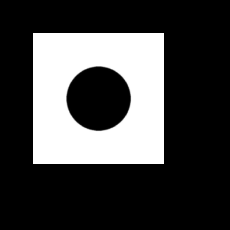

small


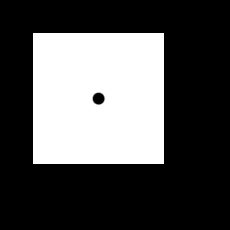

In [8]:
import torch
from torchvision import transforms

#transforms
recep_resize = transforms.Resize((int(recep_field[0][1]-recep_field[0][0]),int(recep_field[1][1]-recep_field[1][0]))) #size of receptive field
totensor = transforms.ToTensor()
topil = transforms.ToPILImage()
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])


cirle_image_tensors = {}
#generate resized/ positioned tensors
for size in circle_images:
    
    #blank backgrounds
    circle_tensor = torch.zeros(3,224,224)
    
    #shrunk images to size of receptive field
    shrunk_circle_tensor = totensor(recep_resize(circle_images[size]))

    #position shrunk images on blanks at receptive field position
    circle_tensor[:,int(recep_field[0][0]):int(recep_field[0][1]),int(recep_field[1][0]):int(recep_field[1][1])] = shrunk_circle_tensor

    #check resultant images (whats actually going to get fed to the model)
    print(size)
    recep_circle_img = topil(circle_tensor)
    recep_circle_wt_border = ImageOps.expand(recep_circle_img, border=border, fill='black')
    display(recep_circle_wt_border)

    # normalize and unsqueeze for passing through model
    circle_tensor = norm(circle_tensor)
    circle_tensor = torch.unsqueeze(circle_tensor,0)
    circle_tensor = circle_tensor.to(device)
    
    cirle_image_tensors[size] = circle_tensor

first we want to just get 'ranks' the sorted importance scores for the components of our network. We can then use those to extract a circuit by thresholding and removing low scoring components. We'll get these scores with respect to a 'small circle' image and a 'large circle' image. The 'dissected' model has the machinery for calculating and storing these scores built in, so we really just have to run the model forward . . .

In [9]:
from circuit_pruner.dissected_Conv2d import set_across_model, set_model_target_node

#setup dissected model hyper params

'''
We set the target in our network to be our feature of interest
'''
set_model_target_node(dissected_model,layer,unit)


"""
We set the 'rank_field' of the model to be [[5,5]], the position in the activation map whose response we'd like
to preserve (in this case, the position that 'sees' our target images). 
Notice we have a list of lists as an argument, this is because we are feeding through minibatches of size 1, 
but if we had bigger minibatches (because we wanted the ranks averaged across a bunch of images) 
we could specify a different position to focus on for each image in the batch.
We also dont have to specify positions at all, we can use the arguments 'image', 'max', or 'min' in place of [[5,5]]
             'image': preserve the average of the activation map
             'max': preserve the max value of the activation map
             'min': preserve the min value of the activation map
             
             default is 'image'
"""
set_across_model(dissected_model,'rank_field',[target_position])


'''
This ones kind of interesting, it means we are going to store the activationsxgradients of our graph components as 
our importance score, rather than the absolute value of that score. This can be useful as we'll see, it could
allow us to find a circuit that increases or decreases the models response to a target image/image patch, 
rather than just preserve the response.
'''
set_across_model(dissected_model,'absolute_rank',False)



AlexNet(
  (features): Sequential(
    (0): dissected_Conv2d(
      (preadd_conv): Conv2d(3, 192, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), groups=3, bias=False)
    )
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): dissected_Conv2d(
      (preadd_conv): Conv2d(64, 12288, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=64, bias=False)
    )
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): dissected_Conv2d(
      (preadd_conv): Conv2d(192, 73728, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192, bias=False)
    )
    (7): ReLU()
    (8): dissected_Conv2d(
      (preadd_conv): Conv2d(384, 98304, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=384, bias=False)
    )
    (9): ReLU()
    (10): dissected_Conv2d(
      (preadd_conv): Conv2d(256, 65536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256, bias=False)
    

In [10]:
#actually extract ranks by running images through model

from circuit_pruner.dissected_Conv2d import get_ranklist_from_dissected_Conv2d_modules, clear_ranks_across_model

ranks = {}
#run images through model
for size in cirle_image_tensors:
    
    in_tensor = cirle_image_tensors[size]
    
    #we want separate ranks for each image, unless we do this, 
    #all ranks are averaged for every image passed through the model.
    clear_ranks_across_model(dissected_model) 
    
    dissected_model.zero_grad()

    #Run model forward until all targets reached, we have this try/except block because the model throws a special
    #error when it reaches all its targets in order to stop the forward pass. This should really be an except
    #that checks for that special error type, but for some reason I cant get that to work across files. (This is very annoying, as it means genuine errors during the forward pass are ignored)
    try:
        outputs = dissected_model(in_tensor)
    except:
        pass
    
    #WHAT ABOUT NO TARGET NODE?
    #just run outputs.backward(), the backward pass triggers hooks through the model


    ranks[size] = get_ranklist_from_dissected_Conv2d_modules(dissected_model)



We can do things with ranks once weve extracted them, like for example calculating a 'diff' rank by simply extracting one from the other. This is why we set 'absolute rank' to False earlier. Now our diff rank will essentially be approximating 'parameters that make the models response to the first image go up, and the response to the second image go down'.

In [11]:
ranks['small-big'] = []
ranks['big-small'] = []

for l in range(len(ranks['small'])):
    ranks['small-big'].append(ranks['small'][l]-ranks['big'][l])
    ranks['big-small'].append(ranks['big'][l]-ranks['small'][l])

In [12]:
#finally lets extract some circuits

from circuit_pruner.extraction import dissected_model_ranks_2_circuit_model

sparsity = .2
feature_targets = {layer:[unit]}    #I know this formatting is weird, it comes from syntax for having linear combinations of units as targets, not shown here

extractions = {}
for size in ranks:
    print(size)
    #returns two formats: a circuit, which is a new smaller neural network, and a simple weight mask
    circuit, mask = dissected_model_ranks_2_circuit_model(ranks[size],sparsity,model,feature_targets,device)
    extractions[size] = {'circuit':circuit,'mask':mask}

big
features_8 effective last layer
target sparsity: 0.2
total params to feature: 86592
kept params in original mask: 17319
original mask: 17319 kernels
effective mask: 11637 kernels
effective_sparsity: 0.1343888580931264
small
features_8 effective last layer
target sparsity: 0.2
total params to feature: 86592
kept params in original mask: 17319
original mask: 17319 kernels
effective mask: 10414 kernels
effective_sparsity: 0.12026515151515152
small-big
features_8 effective last layer
target sparsity: 0.2
total params to feature: 86592
kept params in original mask: 17319
original mask: 17319 kernels
effective mask: 9016 kernels
effective_sparsity: 0.10412047302291205
big-small
features_8 effective last layer
target sparsity: 0.2
total params to feature: 86592
kept params in original mask: 17319
original mask: 17319 kernels
effective mask: 9804 kernels
effective_sparsity: 0.11322062084257206


treat these extracted circuits like new models, you can do all the same stuff with them, like visualizations . . .

  2%|▏         | 8/512 [00:00<00:06, 78.54it/s]

big


100%|██████████| 512/512 [00:05<00:00, 91.33it/s]



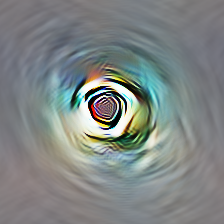

  2%|▏         | 8/512 [00:00<00:06, 72.13it/s]

small


100%|██████████| 512/512 [00:05<00:00, 86.91it/s]



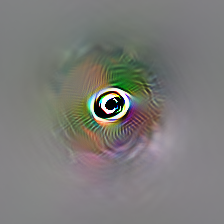

  2%|▏         | 8/512 [00:00<00:06, 78.70it/s]

small-big


100%|██████████| 512/512 [00:05<00:00, 89.81it/s]



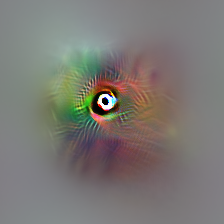

  2%|▏         | 9/512 [00:00<00:06, 82.38it/s]

big-small


100%|██████████| 512/512 [00:05<00:00, 97.18it/s]



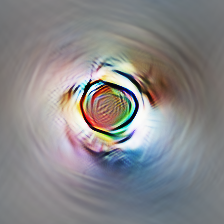

In [15]:
'''
notice we're visualizing the same target node here, but we replace "unit" variable with "0", 
as this layer in the circuit now only has 1 feature, the target node.
'''

obj  = objectives.neuron(layer,0) 


for size in extractions:
    print(size)
    _ = extractions[size]['circuit'].to(device).eval()
    _ = render.render_vis(extractions[size]['circuit'],  obj, param_f, transforms=None, show_inline=True)
